In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_sample_weight

## Downloading files

In [2]:
path_train = '/kaggle/input/playground-series-s4e1/train.csv'
path_test = '/kaggle/input/playground-series-s4e1/test.csv'
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
print(df_train.shape)
df_train.head()

(165034, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Handling duplicates and Null values

In [3]:
df_train.drop(['id', 'CustomerId', 'Surname'], axis=1).duplicated().value_counts()

False    164911
True        123
Name: count, dtype: int64

In [4]:
print("Original shape is", df_train.shape)
df_train = df_train.drop(['id', 'CustomerId', 'Surname'], axis=1)
df_train = df_train.drop_duplicates()
print("Shape after removing duplicates is", df_train.shape)

Original shape is (165034, 14)
Shape after removing duplicates is (164911, 11)


In [5]:
df_train.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df_test.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

## Data visualization

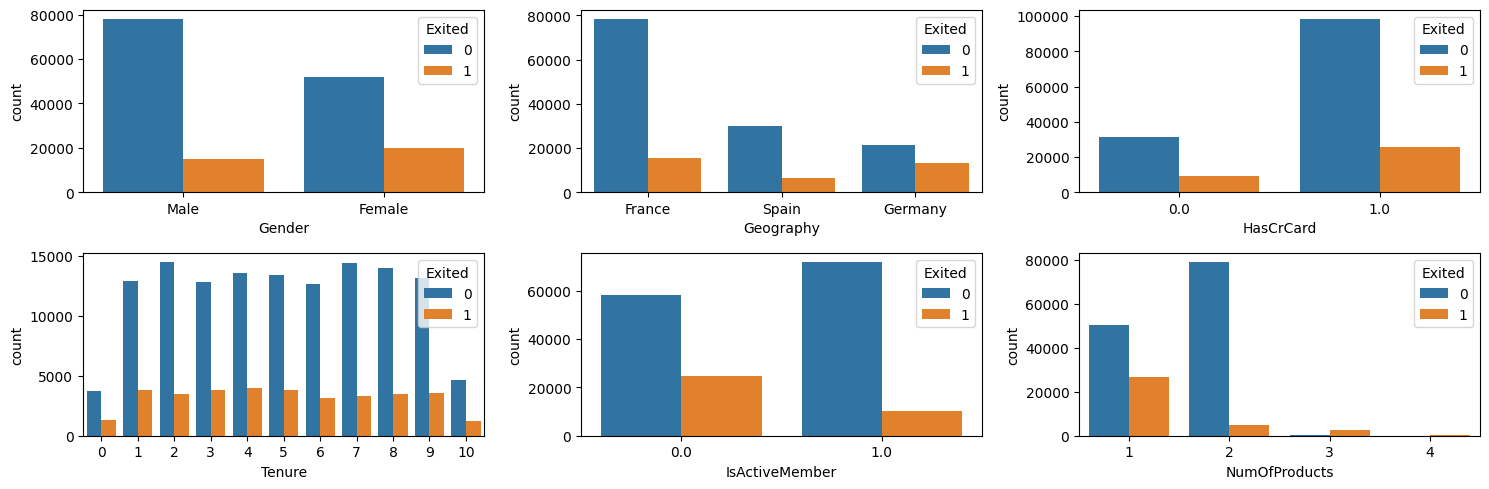

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15,5))
sns.countplot(data=df_train, x='Gender', hue='Exited', ax=axes[0, 0])
sns.countplot(data=df_train, x='Geography', hue='Exited', ax=axes[0, 1])
sns.countplot(data=df_train, x='HasCrCard', hue='Exited', ax=axes[0, 2])
sns.countplot(data=df_train, x='Tenure', hue='Exited', ax=axes[1, 0])
sns.countplot(data=df_train, x='IsActiveMember', hue='Exited', ax=axes[1, 1])
sns.countplot(data=df_train, x='NumOfProducts', hue='Exited', ax=axes[1, 2])
plt.tight_layout()
plt.show()

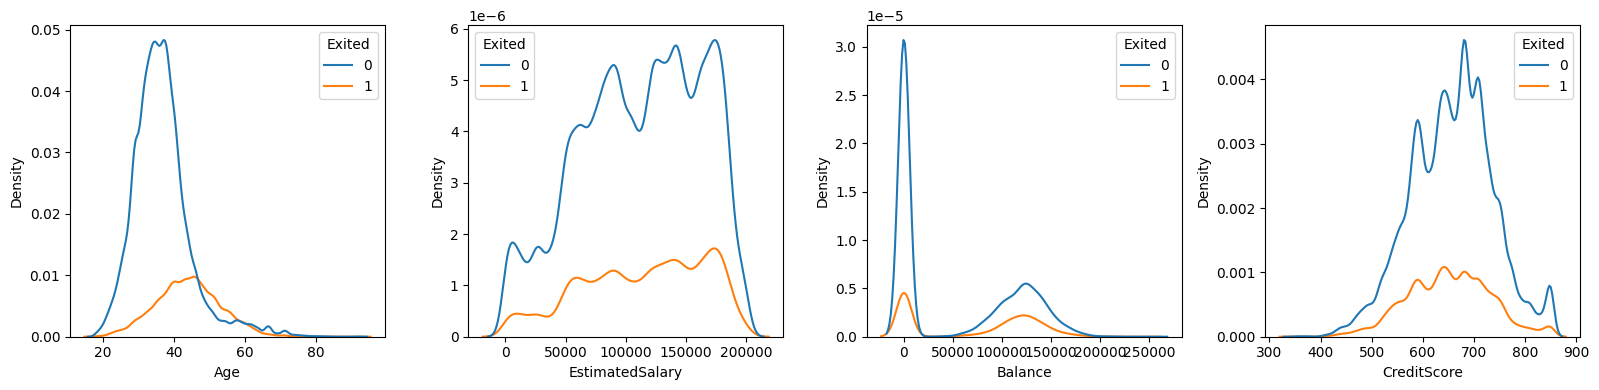

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))
sns.kdeplot(data=df_train, x='Age', hue='Exited', bw_adjust=1, ax=axes[0])
sns.kdeplot(data=df_train, x='EstimatedSalary', hue='Exited', bw_adjust=1, ax=axes[1])
sns.kdeplot(data=df_train, x='Balance', hue='Exited', bw_adjust=1, ax=axes[2])
sns.kdeplot(data=df_train, x='CreditScore', hue='Exited', bw_adjust=1, ax=axes[3])
plt.tight_layout()
plt.show()

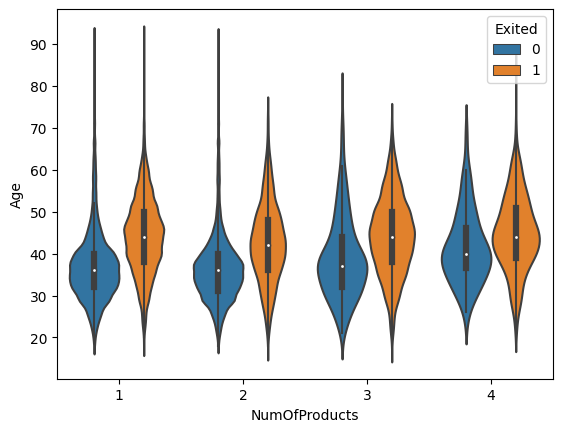

In [9]:
sns.violinplot(data=df_train, x='NumOfProducts', y='Age', hue='Exited', dodge=True);

<Axes: xlabel='NumOfProducts', ylabel='Balance'>

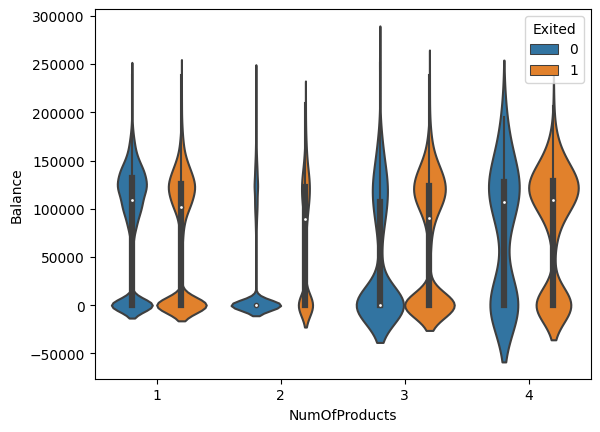

In [10]:
sns.violinplot(data=df_train, x='NumOfProducts', y='Balance', hue='Exited', dodge=True)

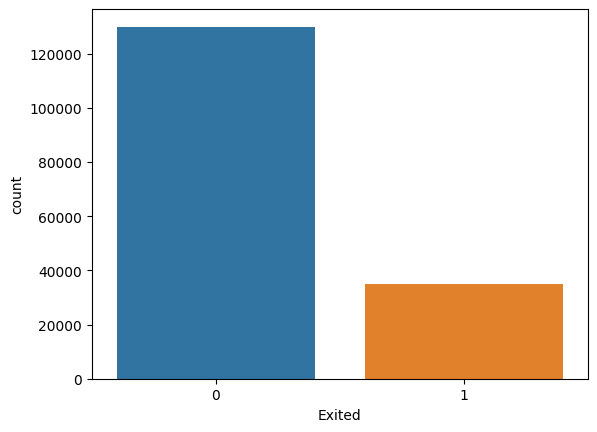

In [11]:
# Unbalanced data, as there are mainly people staying than leaving the bank
sns.countplot(data=df_train, x='Exited');

## Data Cleaning

In [12]:
# Check typo with age values
df_train['age_test'] = df_train['Age'].astype(str)
df_train['age_test'] = df_train['age_test'].str[-2:]
df_train['age_test'].value_counts()

age_test
.0    164909
44         1
34         1
Name: count, dtype: int64

In [13]:
# Check typo with age values
df_test['age_test'] = df_test['Age'].astype(str)
df_test['age_test'] = df_test['age_test'].str[-2:]
df_test['age_test'].value_counts()

age_test
.0    110014
34         4
25         2
44         2
64         1
Name: count, dtype: int64

In [14]:
df_train.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_test
0,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0,.0


In [15]:
df_test.head(1)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,age_test
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.0,2,0.0,1.0,160976.75,.0


In [16]:
def clean_df(df, test=False):
    # Encoding gender
    gender_dummies = pd.get_dummies(df['Gender'], drop_first=False, dtype=int)
    df = df.join(gender_dummies)

    # Encoding countries
    country_dummies = pd.get_dummies(df['Geography'], drop_first=False, dtype=int)
    df = df.join(country_dummies)

    # One-hot encoding for Tenure and Num of products discrete values
    tenure_options = pd.get_dummies(df['Tenure'], drop_first=True, dtype=int)
    tenure_cols = [f'Tenure_{i}' for i in tenure_options.columns]
    df[tenure_cols] = tenure_options

    num_prod_options = pd.get_dummies(df['NumOfProducts'], drop_first=False, dtype=int)
    num_prod_cols = [f'NumProds_{i}' for i in num_prod_options.columns]
    df[num_prod_cols] = num_prod_options

    # Adding balance column boolean to know if they have money in the account
    df['zero_balance'] = (df['Balance'] == 0).astype(int)
    
    # Adding best age column
    # df['Best Age'] = (df['Age'] >= 35) & (df['Age'] <= 55)
    # df['Best Age'] = df['Best Age'].astype(int)
    
    # Creating df for heatmap
    if not test:
        # df_hm = df[['CreditScore', 'France', 'Germany', 'Spain', 'Tenure', 'NumOfProducts', 'Male', 'Age', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Best Age', 'Exited']]
        df_hm = df[['CreditScore', 'France', 'Germany', 'Spain', 'Tenure', 'NumOfProducts', 'Male', 'Age', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']]
        
    # Removing redundant columns
    df = df.drop(['age_test', 'Geography', 'Tenure', 'NumOfProducts', 'Female', 'Gender'], axis=1)
    
    # Making columns int
    df[['IsActiveMember', 'HasCrCard', 'Age']] = df[['IsActiveMember', 'HasCrCard', 'Age']].astype(int)
    
    # Removing columns
    if test:
        df = df.drop(['id', 'CustomerId', 'Surname'], axis=1)
        df[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']] = data_scaler.fit_transform(df[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']])
        return df

    return df, df_hm

In [17]:
df_train, df_hm = clean_df(df_train)
df_train.head()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,France,Germany,...,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumProds_1,NumProds_2,NumProds_3,NumProds_4,zero_balance
0,668,33,0.00,1,0,181449.97,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1
1,627,33,0.00,1,1,49503.50,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1
2,678,40,0.00,1,0,184866.69,0,1,1,0,...,0,0,0,0,1,0,1,0,0,1
3,581,34,148882.54,1,1,84560.88,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
4,716,33,0.00,1,1,15068.83,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


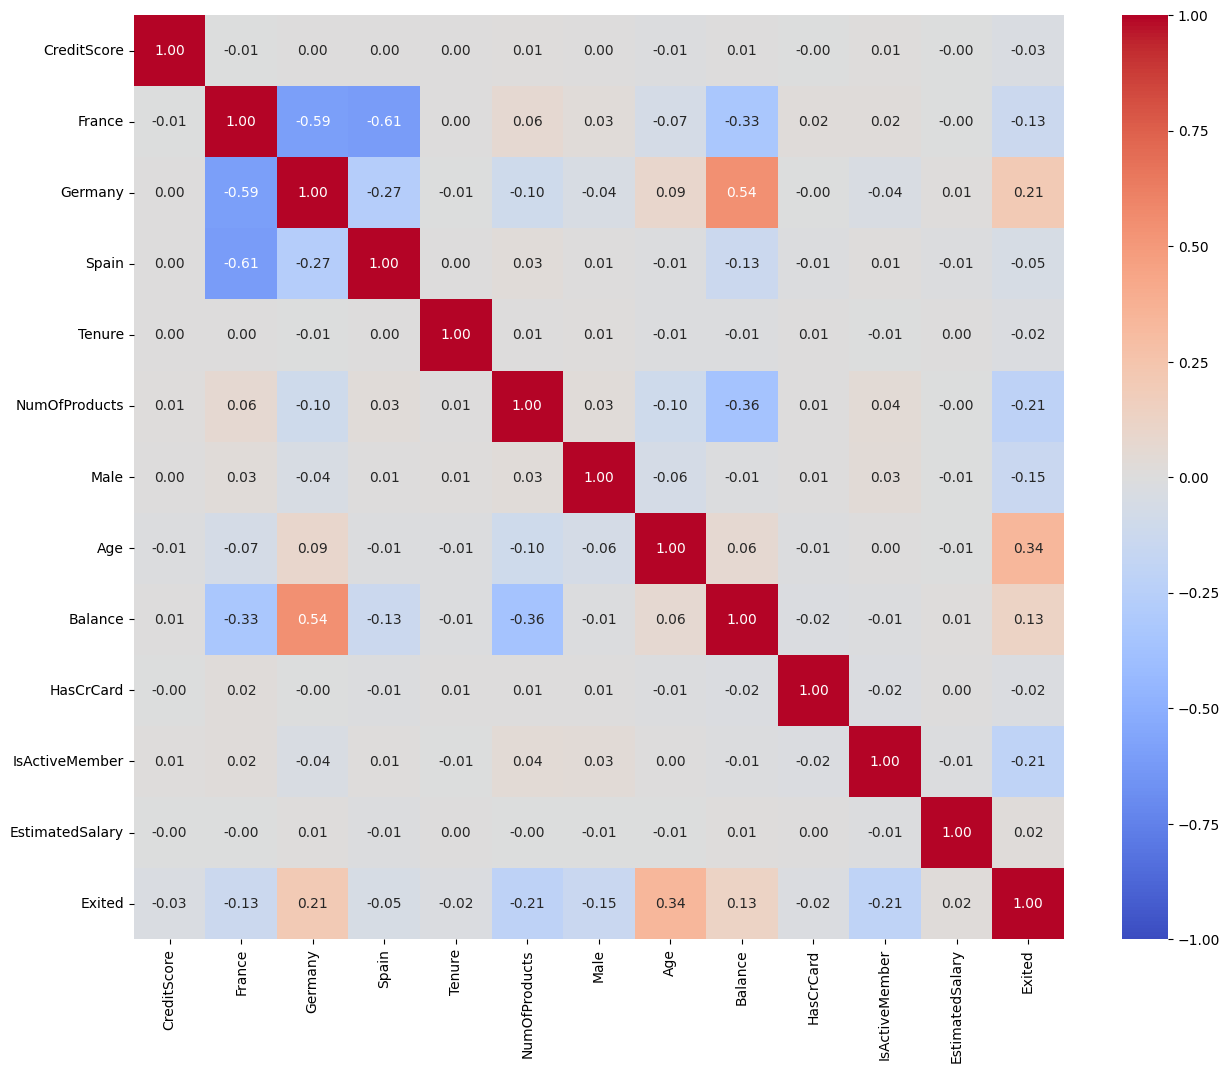

In [18]:
plt.figure(figsize = (15,12))
sns.heatmap(
    data=df_hm.corr(),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    fmt='.2f'
)
plt.show()

## Testing models

In [19]:
X = df_train.drop(['Exited'], axis=1)
y = df_train['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Scaling the continuous data
data_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']] = data_scaler.fit_transform(X_train[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']])
X_val[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']] = data_scaler.fit_transform(X_val[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']])

# Calculating weights
w0 = y_train.count() / (2.0 * y_train[y_train == 0].count())
w1 = y_train.count() / (2.0 * y_train[y_train == 1].count())
weights = {0: w0, 1: w1}
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

Logistic Regression Results


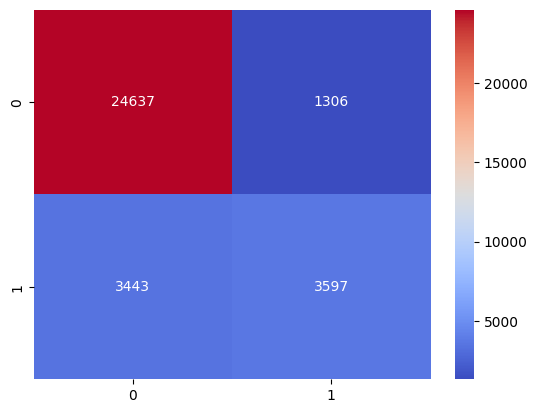

---------------------------------------------------------------------------
XGB Results


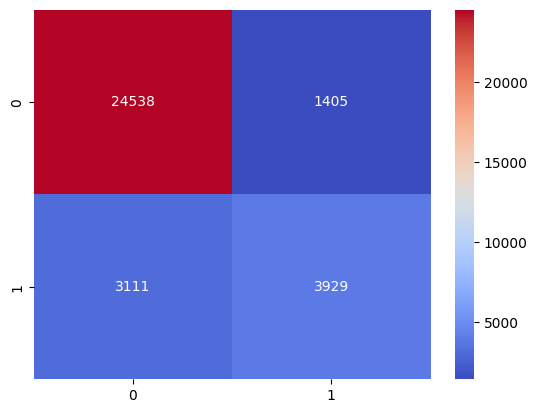

---------------------------------------------------------------------------
Catboost Results


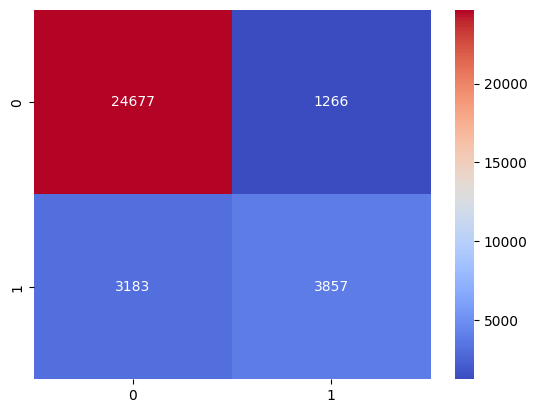

---------------------------------------------------------------------------
LR w Weights Results


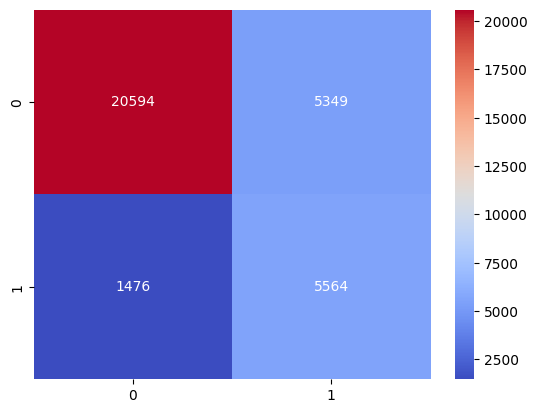

---------------------------------------------------------------------------
XGB w Weights Results


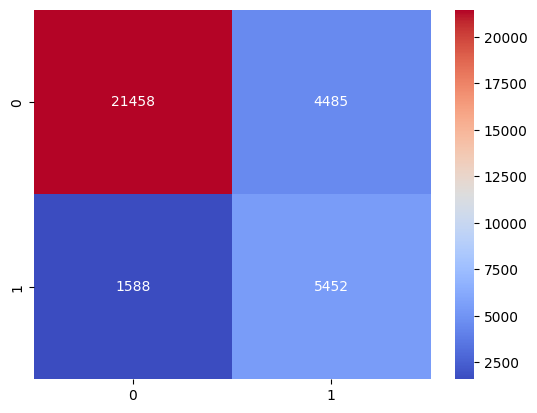

---------------------------------------------------------------------------
Catboost w Weights Results


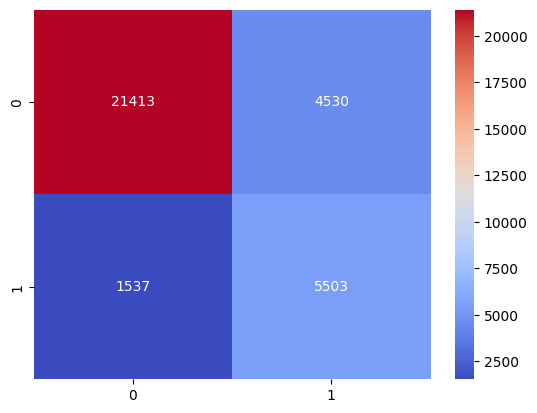

---------------------------------------------------------------------------


In [20]:
models, accuracy, precision, recall, auc = dict(), dict(), dict(), dict(), dict()

models['Logistic Regression'] = LogisticRegression(random_state=42, max_iter=150)
models['XGB'] = XGBClassifier(random_state=42)
models['Catboost'] = CatBoostClassifier(random_state=42, verbose=False)

models['LR w Weights'] = LogisticRegression(random_state=42, max_iter=150, class_weight=weights)
models['XGB w Weights'] = XGBClassifier(random_state=42, scale_pos_weight=ratio)
models['Catboost w Weights'] = CatBoostClassifier(random_state=42, class_weights=weights, verbose=False)

for model_name in models.keys():
    models[model_name].fit(X_train, y_train)
    y_val_pred = models[model_name].predict(X_val)
    
    accuracy[model_name] = accuracy_score(y_val_pred, y_val)
    precision[model_name] = precision_score(y_val_pred, y_val)
    recall[model_name] = recall_score(y_val_pred, y_val)
    auc[model_name] = roc_auc_score(y_val, y_val_pred)
    
    # Visualization of confusion matrix
    fp, tp, _ = roc_curve(y_val, y_val_pred)
    print(model_name + ' Results')
    sns.heatmap(confusion_matrix(y_val, y_val_pred), fmt='', annot=True, cmap='coolwarm')
    plt.show()
    print("-" * 75)

In [21]:
df_results = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'AUC'])
df_results['Accuracy'] = accuracy.values()
df_results['Precision'] = precision.values()
df_results['Recall'] = recall.values()
df_results['AUC'] = auc.values()
df_results = df_results.reset_index()
df_results

,index,Accuracy,Precision,Recall,AUC
0,Logistic Regression,0.856017,0.510938,0.733632,0.730298
1,XGB,0.863081,0.558097,0.736595,0.751970
2,Catboost,0.865112,0.547869,0.752879,0.749535
3,LR w Weights,0.793075,0.790341,0.509851,0.792079
4,XGB w Weights,0.815875,0.774432,0.548657,0.800776
5,Catboost w Weights,0.816057,0.781676,0.548490,0.803531


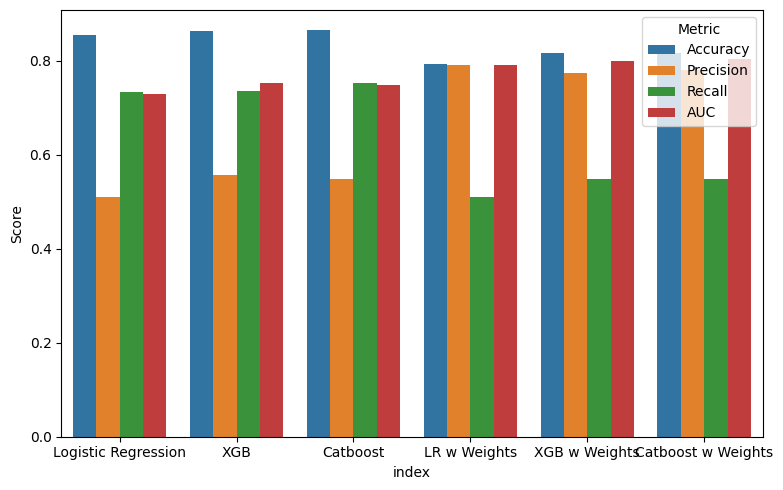

In [22]:
# Plotting results
df_results_melt = pd.melt(df_results, id_vars=['index'], var_name='Metric', value_name='Score')
plt.figure(figsize=(8, 5))
sns.barplot(data=df_results_melt, x='index', y='Score', hue='Metric')
plt.tight_layout()
plt.show()

In [23]:
# X_test = clean_df(df_test, True)
# best_model = CatBoostClassifier(random_state=42, class_weights=weights, verbose=False)
# best_model.fit(X_train, y_train)
# X_test_probs = best_model.predict_proba(X_test)
# ids = df_test['id'].to_list()
# exit_prob = list(X_test_probs[:, 1])

In [24]:
# df_submit = pd.DataFrame({'id': ids, 'Exited': exit_prob})
# df_submit.head()

In [25]:
# df_submit.to_csv('submission.csv', index=False)

## Testing zone

In [26]:
accs, aucs, models = list(), list(), list()

skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx].copy(), y.iloc[train_idx].copy()
    X_val, y_val = X.iloc[val_idx].copy(), y.iloc[val_idx].copy()
    
    # Scaling the continuous data
    data_scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']] = data_scaler.fit_transform(X_train[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']])
    X_val[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']] = data_scaler.fit_transform(X_val[['CreditScore', 'Age', 'EstimatedSalary', 'Balance']])

    # Calculating weights
    w0 = y_train.count() / (2.0 * y_train[y_train == 0].count())
    w1 = y_train.count() / (2.0 * y_train[y_train == 1].count())
    weights = {0: w0, 1: w1}
    ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])
    
    best_model = CatBoostClassifier(random_state=42, class_weights=weights, verbose=False)
    best_model.fit(X_train, y_train)
    models.append(best_model)
    y_val_pred = best_model.predict(X_val)
    accs.append(accuracy_score(y_val_pred, y_val))
    aucs.append(roc_auc_score(y_val, y_val_pred))
    print(f'In fold {i}, accuracy={accs[-1]} | auc={aucs[-1]}')

In fold 0, accuracy=0.8155060758204177 | auc=0.8037263252118751
In fold 1, accuracy=0.8143350918682918 | auc=0.8014605246388334
In fold 2, accuracy=0.8168455521193378 | auc=0.8036185803926785
In fold 3, accuracy=0.8142259414225942 | auc=0.8001340225831151
In fold 4, accuracy=0.8207385846825541 | auc=0.8103624991696323
In fold 5, accuracy=0.8196106967436784 | auc=0.8061896265932054


In [27]:
X_test = clean_df(df_test, True)
X_test_probs = models[4].predict_proba(X_test)
ids = df_test['id'].to_list()
exit_prob = list(X_test_probs[:, 1])
df_submit = pd.DataFrame({'id': ids, 'Exited': exit_prob})
df_submit.head()

,id,Exited
0,165034,0.159900
1,165035,0.948726
2,165036,0.066312
3,165037,0.543553
4,165038,0.646170


In [28]:
df_submit.to_csv('submission.csv', index=False)